### Imports  

In [1]:
from Utils import *

### NPZ to DF and sono visualizations

In [2]:
#dfs creation from npz
folder_path = r"C:\Users\stebi\Desktop\potatoes\1800"
dataframes = load_npz_files(folder_path)
for name, df in dataframes.items():
    globals()[name] = df

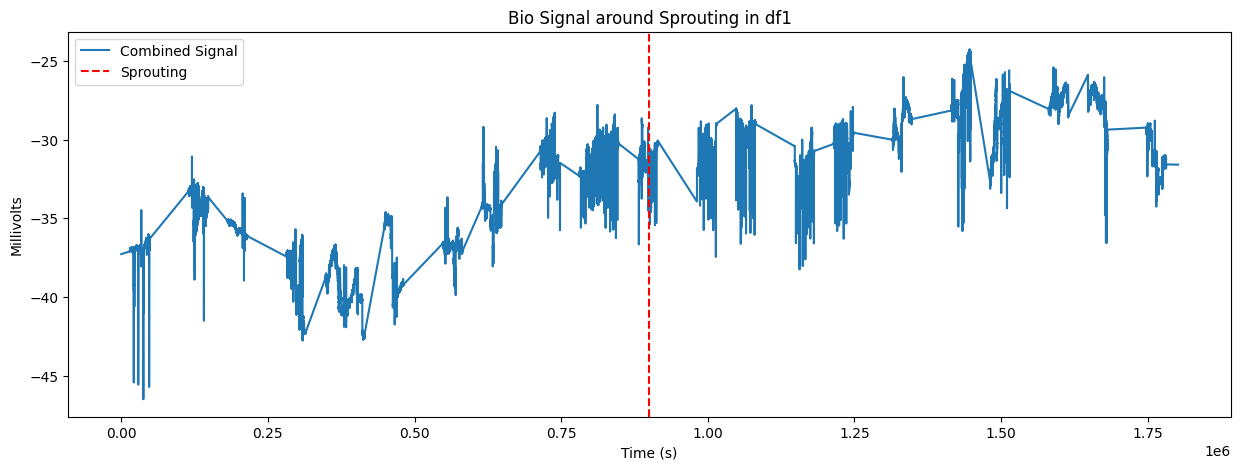

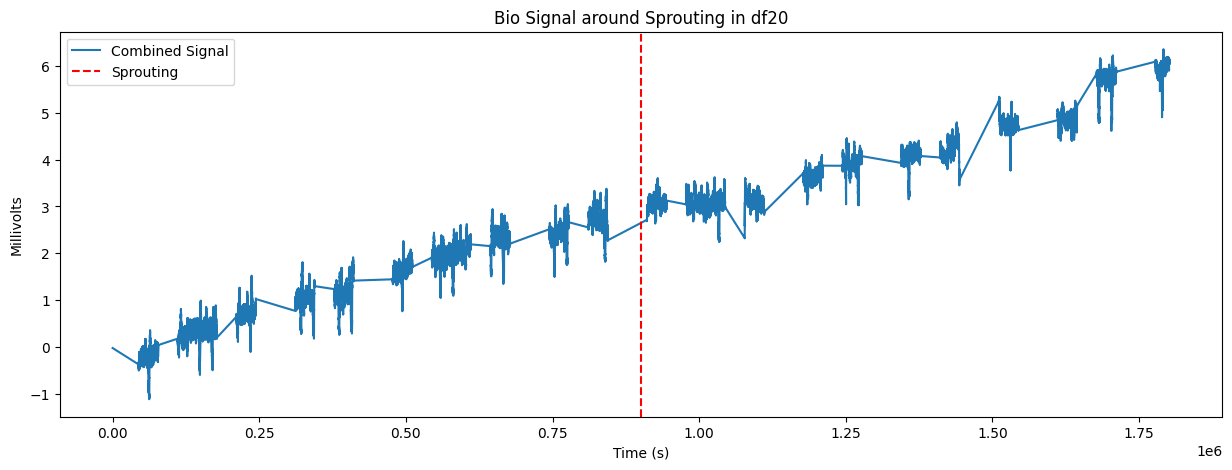

In [3]:
#before and after the sprouting
plot_bio_signal(df1, 'df1')
plot_bio_signal(df20, 'df20')

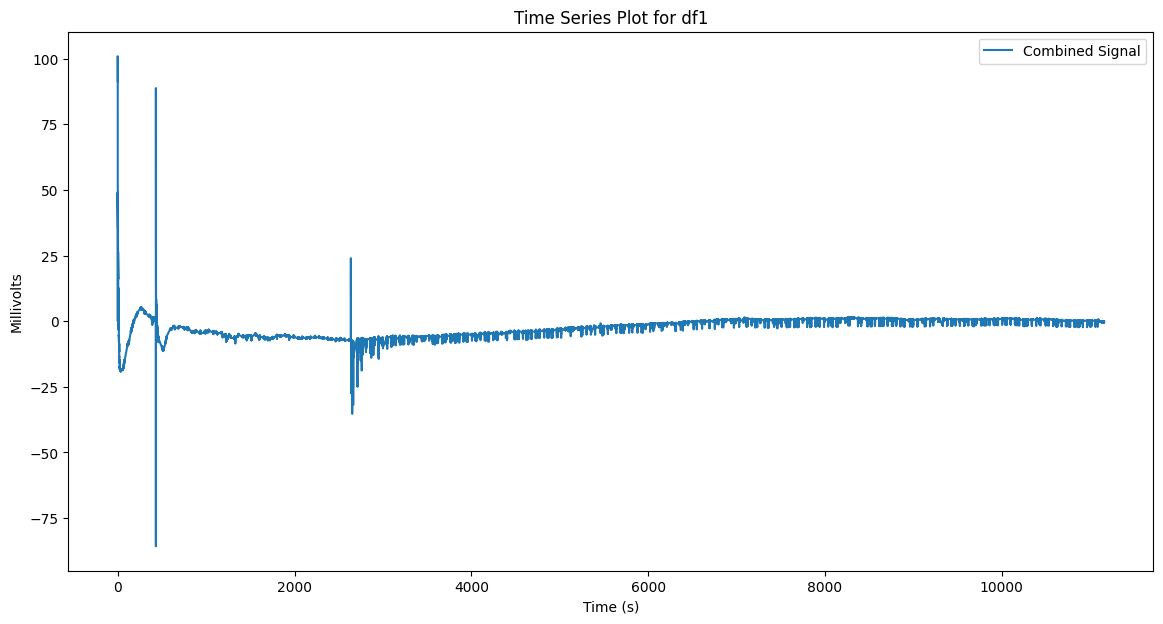

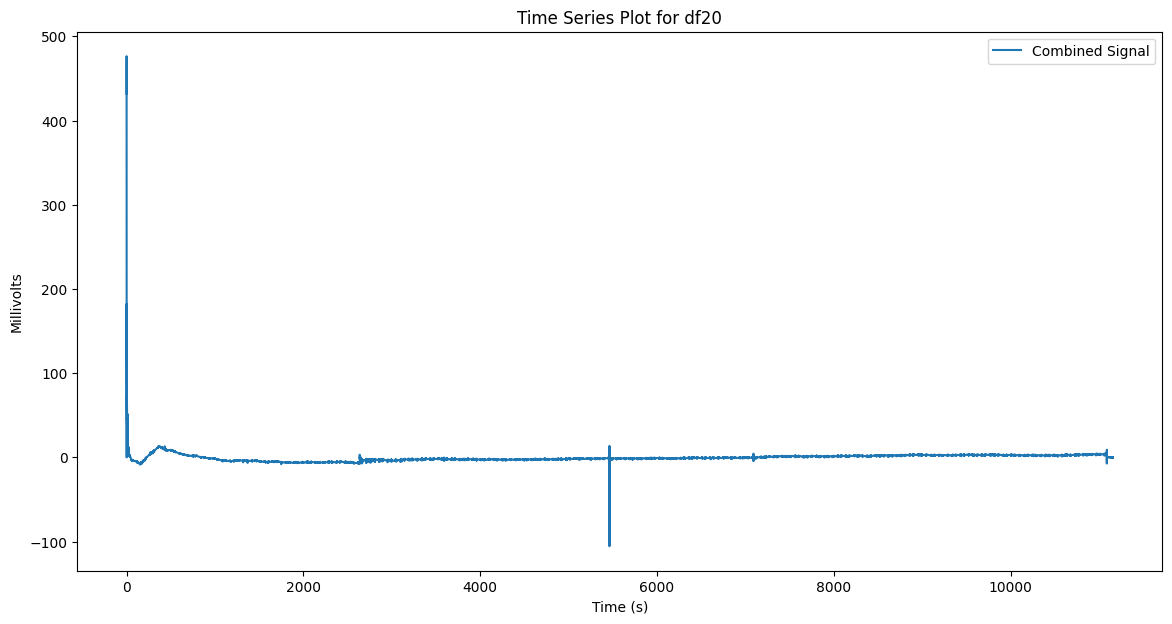

In [4]:
plot_time_series(df10, 'Time Series Plot for df1')
plot_time_series(df15, 'Time Series Plot for df20')

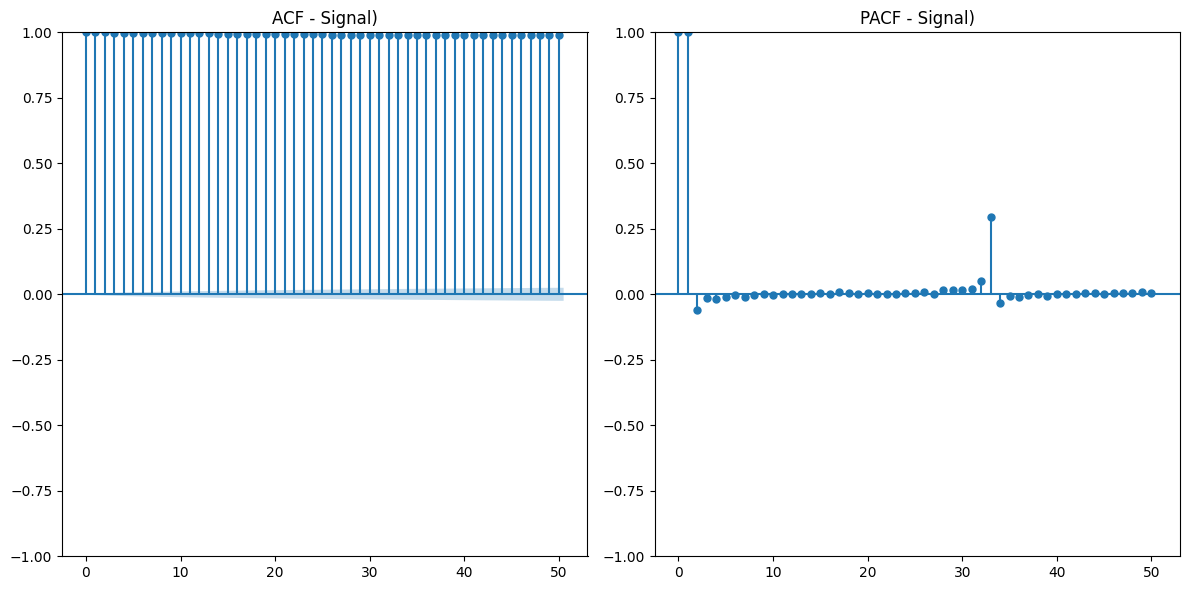

In [5]:
#ACF e PACF
filtered_df1 = df1.loc[df1['y'] <= 0]
combined_signal = filtered_df1.drop(columns='y', errors='ignore').values.flatten()
downsampled_signal = downsample_signal(combined_signal, factor=10) 
plot_acf_pacf(downsampled_signal, 'Signal)')

In [6]:
#check stationarity
stationarity_results_df1 = check_combined_stationarity_kpss(df1)
for key, value in stationarity_results_df1.items():
    print(f"{key}: {value}")

Test Statistic: 48.294028615659315
p-value: 0.01
Lags Used: 1724
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationarity: Non-stationary


c:\Users\stebi\Desktop\TESI\Thesis\Utils\stationarity.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(combined_signal, regression='c', nlags='auto')


In [7]:
#filter out rows with y > 0
import pandas as pd

def filter_dataframes(num_dataframes):
    filtered_dataframes = {}
    
    for i in range(1, num_dataframes + 1):
        df_name = f'df{i}'
        df = globals().get(df_name)
        if df is not None:
            filtered_df = df[df['y'] <= 0]
            filtered_dataframes[df_name] = filtered_df

    return filtered_dataframes

filtered_dataframes = filter_dataframes(32)

### Windowing

In [8]:
#windowing
processed_dataframes_6 = window(filtered_dataframes, 6)
processed_dataframes_12 = window(filtered_dataframes, 12)
processed_dataframes_18 = window(filtered_dataframes, 18)
processed_dataframes_24 = window(filtered_dataframes, 24)

### Normalization

In [9]:
#normalization
normalized_dataframes_6 = normalize(processed_dataframes_6)
normalized_dataframes_12 = normalize(processed_dataframes_12)
normalized_dataframes_18 = normalize(processed_dataframes_18)
normalized_dataframes_1_day = normalize(processed_dataframes_24)

### Feature generation

In [10]:
#featgen
extracted_features_6 = featgen(normalized_dataframes_6)
extracted_features_12 = featgen(normalized_dataframes_12)
extracted_features_18 = featgen(normalized_dataframes_18)
extracted_features_1_day = featgen(normalized_dataframes_1_day)

combined_features_6 = combined(extracted_features_6)
combined_features_12 = combined(extracted_features_12)
combined_features_18 = combined(extracted_features_18)
combined_features_1_day = combined(extracted_features_1_day)

### Scaling

In [11]:
#scaling
scal_norm_dataframes_6 = scale(combined_features_6, target_column='y')
scal_norm_dataframes_12 = scale(combined_features_12, target_column='y')
scal_norm_dataframes_18 = scale(combined_features_18, target_column='y')
scal_norm_dataframes_1_day = scale(combined_features_1_day, target_column='y')


## Regression
### Define models

In [12]:
#define models
models = {
    'XGB': XGBRegressor(),
    'ADAB': AdaBoostRegressor(),
    'LGBM': lgb.LGBMRegressor()
}

### Modelling with scaling and normalization

In [13]:
#modelling, scal + norm
dictionaries = {
    '6_h_window': scal_norm_dataframes_6,
    '12_h_window': scal_norm_dataframes_12,
    '18_h_window': scal_norm_dataframes_18,
    '1_d_window': scal_norm_dataframes_1_day
}

results, individual_maes, individual_predictions = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h_window...
  Using model XGB...
    Average MAE: 26.0607
  Using model ADAB...
    Average MAE: 31.6678
  Using model LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6660
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6660
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001830 seconds.
You 

In [19]:
#mean day pred
mean_days = day_predict(individual_predictions)
prettyp(mean_days)


Mean day of prediction for 6_h_window:
  XGB: Mean prediction date and time = 2024-08-23 18:04:32.218101
  ADAB: Mean prediction date and time = 2024-08-31 04:03:25.218101
  LGBM: Mean prediction date and time = 2024-08-23 22:51:29.218101

Mean day of prediction for 12_h_window:
  XGB: Mean prediction date and time = 2024-08-24 15:29:41.218101
  ADAB: Mean prediction date and time = 2024-09-02 08:01:51.218101
  LGBM: Mean prediction date and time = 2024-08-24 13:22:23.218101

Mean day of prediction for 18_h_window:
  XGB: Mean prediction date and time = 2024-08-24 06:42:07.218101
  ADAB: Mean prediction date and time = 2024-09-02 00:44:55.218101
  LGBM: Mean prediction date and time = 2024-08-24 01:24:01.218101

Mean day of prediction for 1_d_window:
  XGB: Mean prediction date and time = 2024-08-24 10:03:43.218101
  ADAB: Mean prediction date and time = 2024-08-31 02:55:22.218101
  LGBM: Mean prediction date and time = 2024-08-24 07:46:50.218101


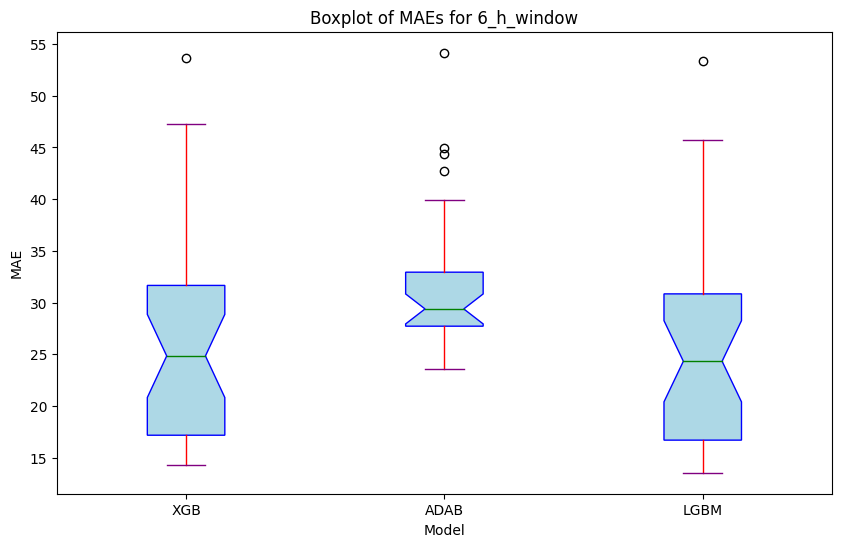

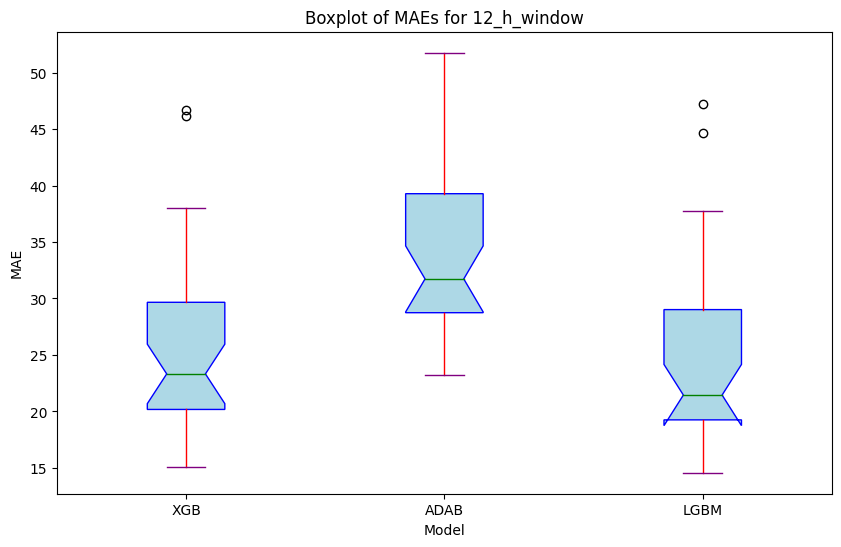

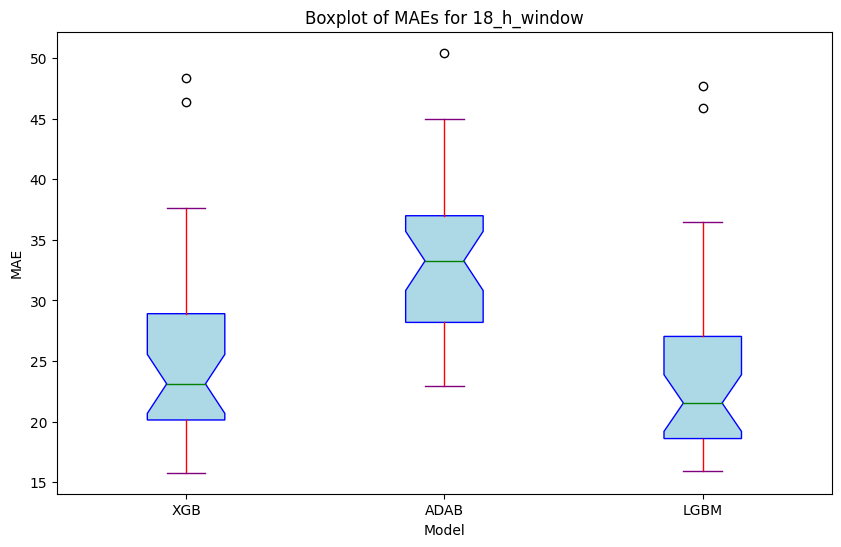

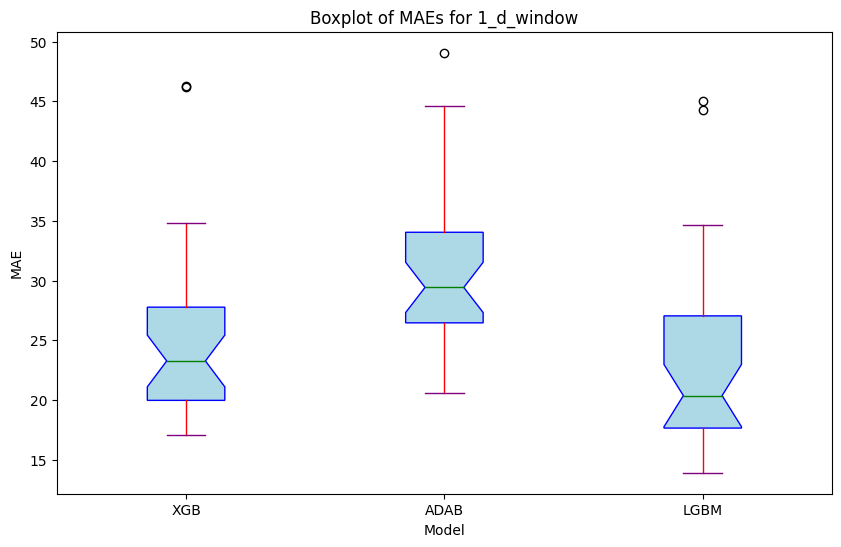

In [15]:
#boxplots
create_boxplots(individual_maes)

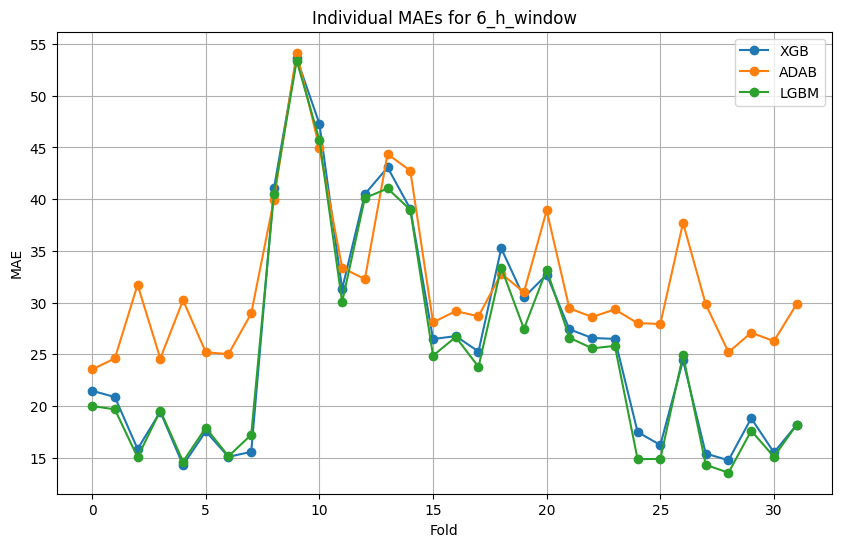

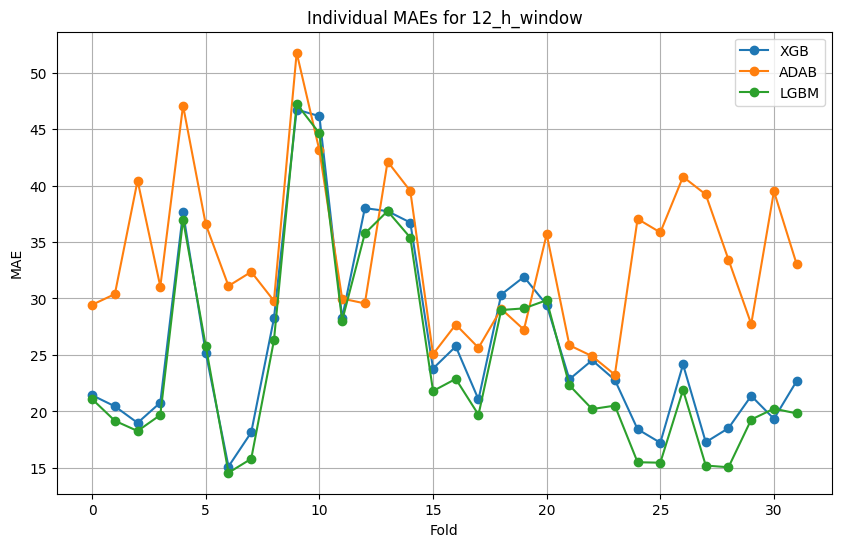

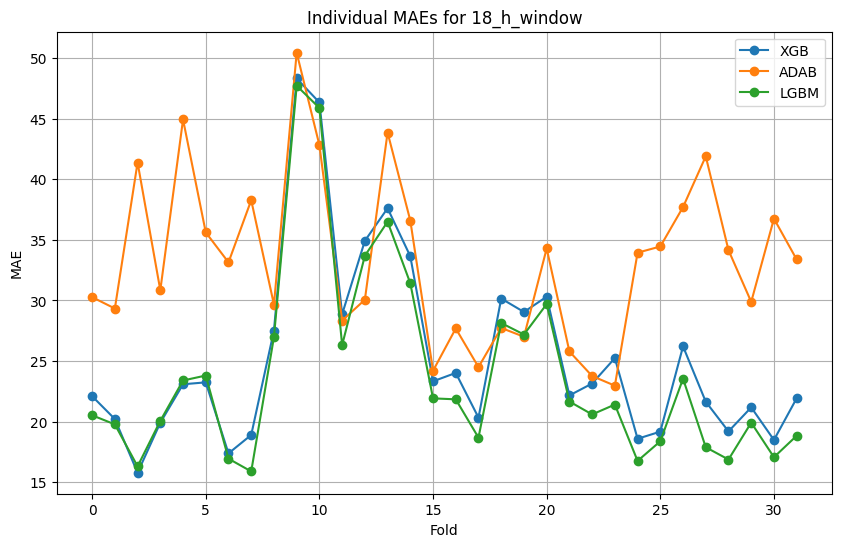

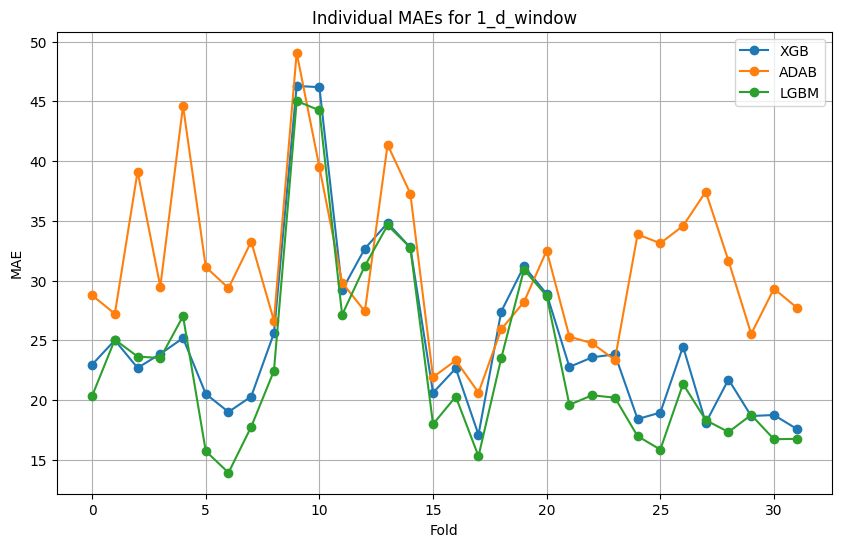

In [16]:
#line plot
plot_lines(individual_maes)

## Comparison df9 against others

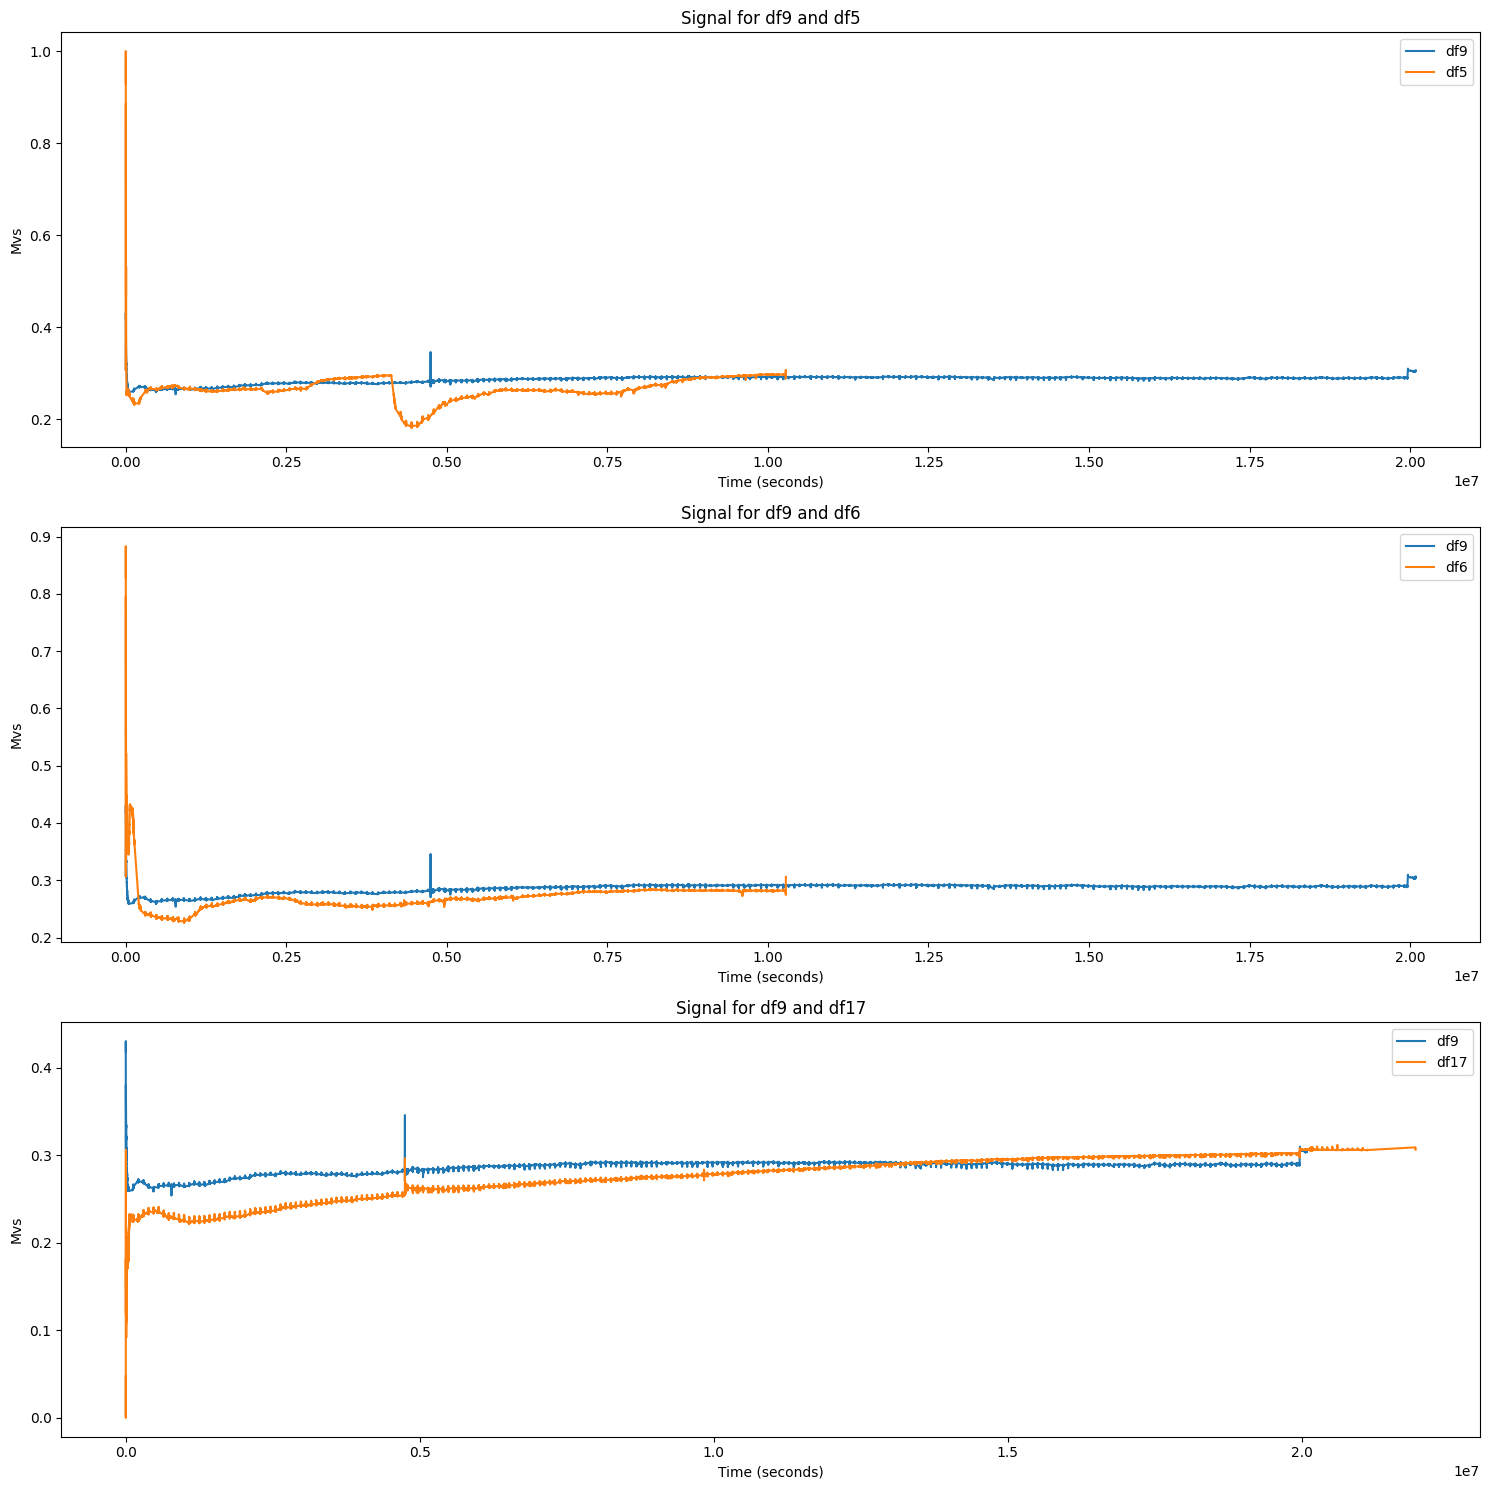

In [17]:
# raw df6, 5, 17 against raw df9
df_reference = df9
dfs_to_compare = [df5, df6, df17]
labels = ['df5', 'df6', 'df17']

comparison(df_reference, dfs_to_compare, labels)

### Modelling with normalization

In [18]:
#modelling,  only norm
dictionaries = {
    '6_h': combined_features_6,
    '12_h': combined_features_12,
    '18_h': combined_features_18,
    '1_d': combined_features_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 35.4459
  Using model ADAB...
    Average MAE: 41.3318
  Using model LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 27
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 27
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set

KeyboardInterrupt: 

In [ ]:
#mean day pred
mean_days = day_predict(individual_maes)
prettyp(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-24 21:56:28.586668
  ADAB: Mean prediction date and time = 2024-07-30 07:07:26.586668
  LGBM: Mean prediction date and time = 2024-07-23 22:17:30.586668

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-24 23:47:53.586668
  ADAB: Mean prediction date and time = 2024-07-30 23:38:44.586668
  LGBM: Mean prediction date and time = 2024-07-23 13:27:07.586668

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-26 10:00:11.586668
  ADAB: Mean prediction date and time = 2024-07-30 23:14:54.586668
  LGBM: Mean prediction date and time = 2024-07-24 12:47:02.586668

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-24 08:57:46.586668
  ADAB: Mean prediction date and time = 2024-07-28 08:45:54.586668
  LGBM: Mean prediction date and time = 2024-07-22 10:10:16.586668


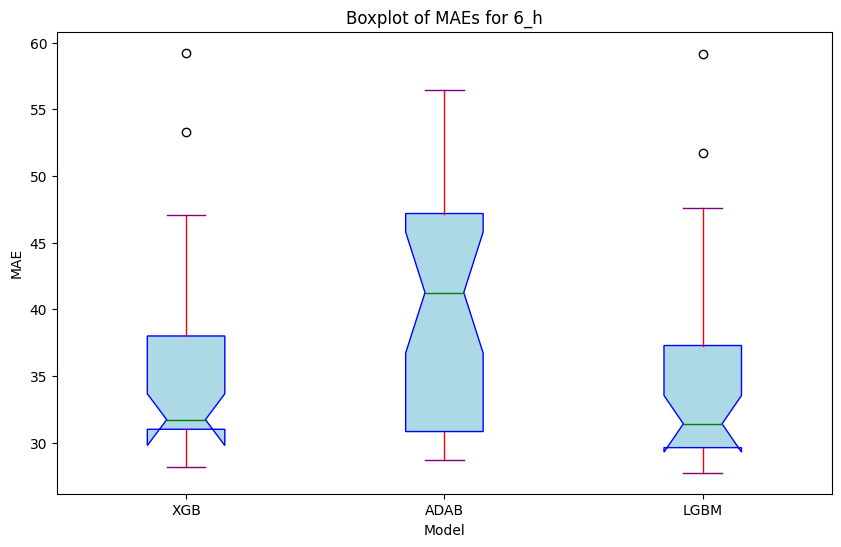

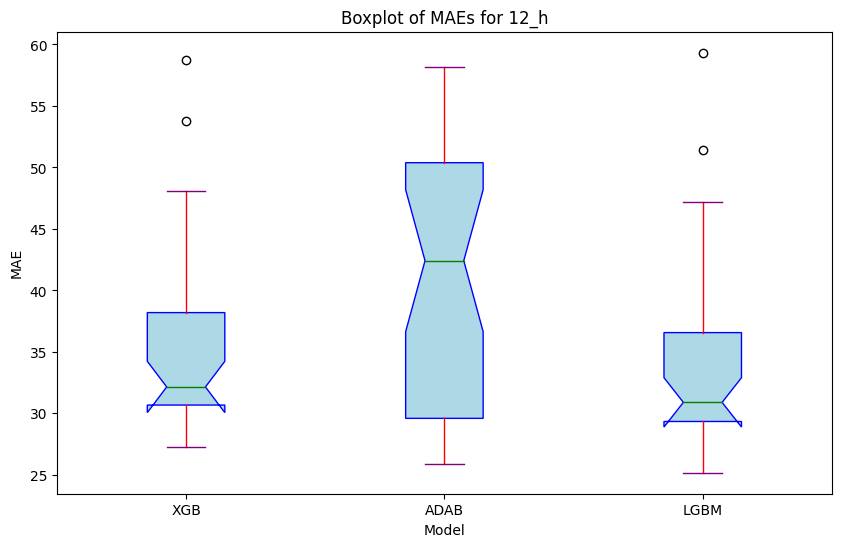

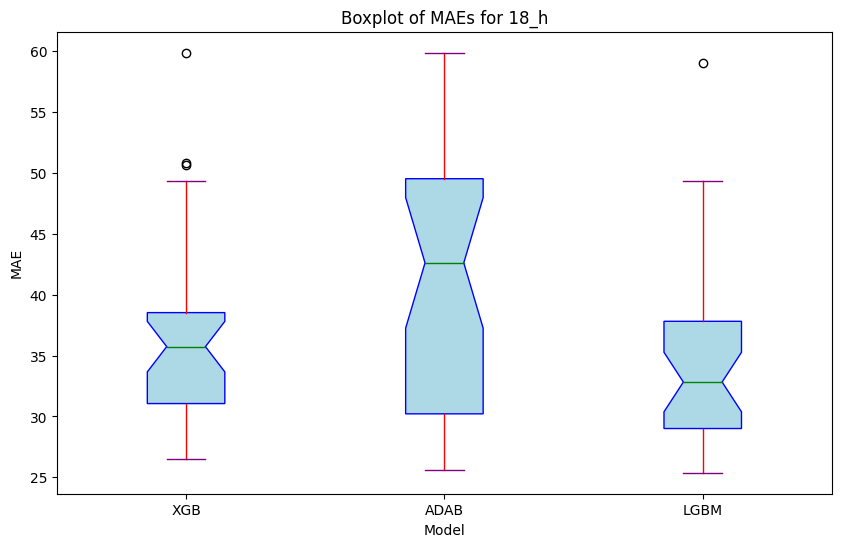

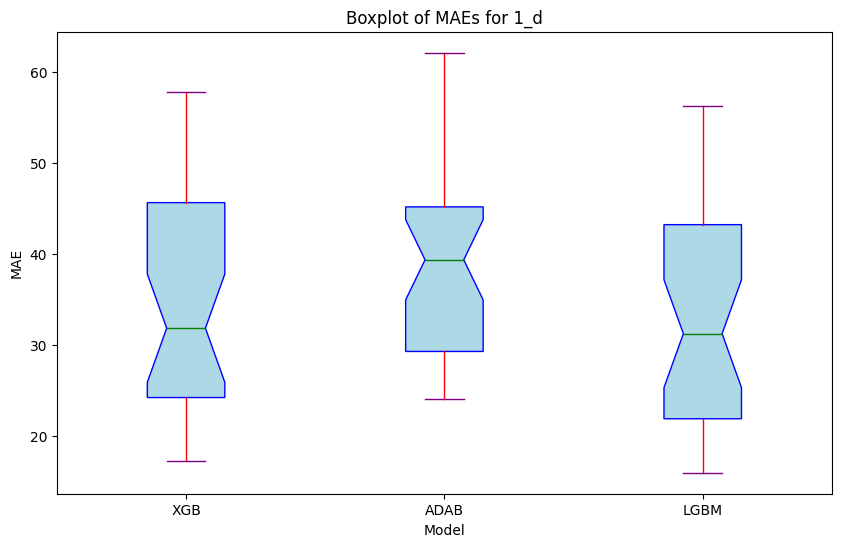

In [ ]:
#boxplot
create_boxplots(individual_maes)

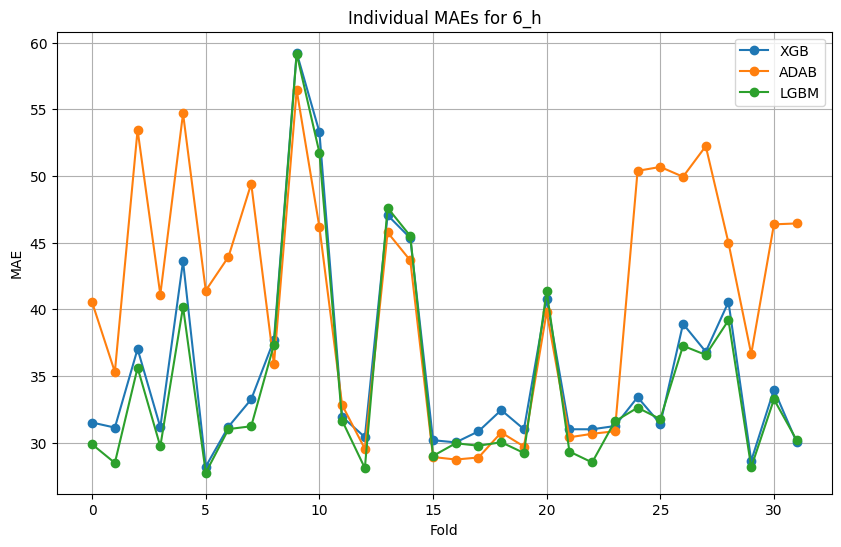

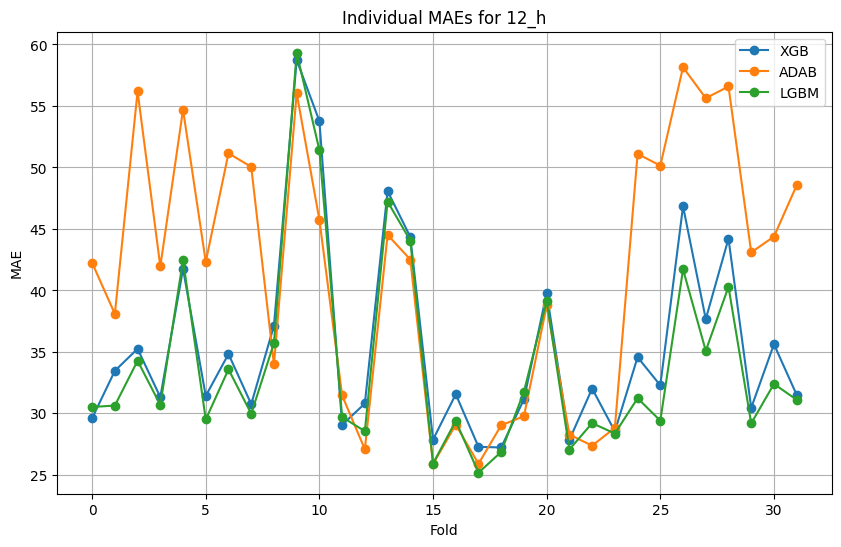

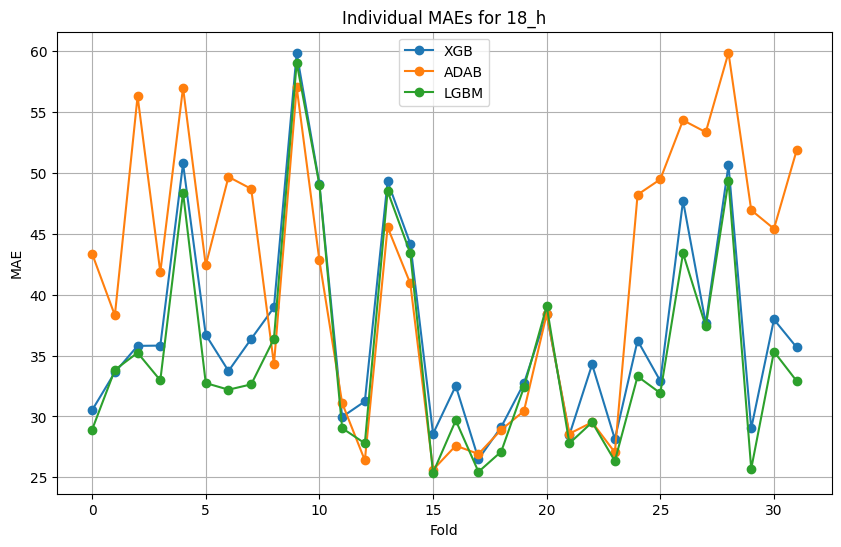

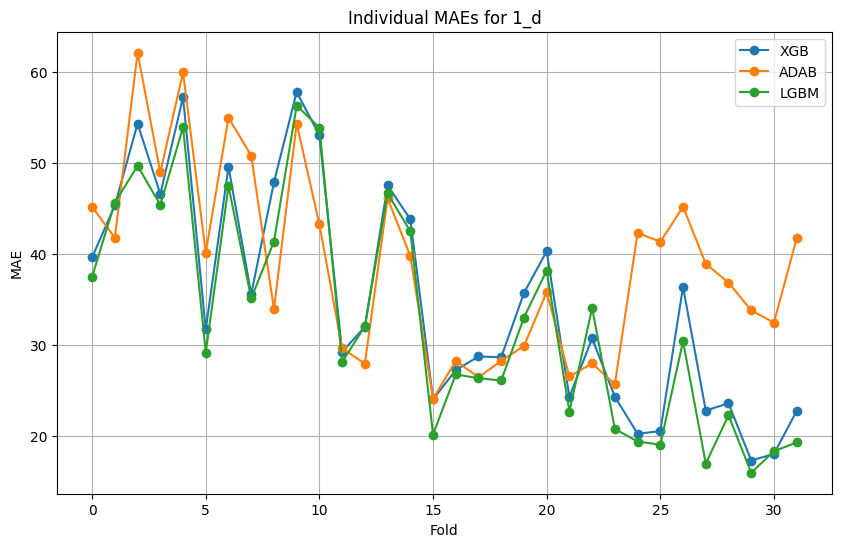

In [ ]:
#line plot
plot_lines(individual_maes)

### Modelling without scaling or normalization

In [ ]:
#featgen, original data no normalization
extracted_features_6 = featgen(processed_dataframes_6)
extracted_features_12 = featgen(processed_dataframes_12)
extracted_features_18 = featgen(processed_dataframes_18)
extracted_features_1_day = featgen(processed_dataframes_24)

combined_features_6 = combined(extracted_features_6)
combined_features_12 = combined(extracted_features_12)
combined_features_18 = combined(extracted_features_18)
combined_features_1_day = combined(extracted_features_1_day)

In [ ]:
#modelling, no scale no norm
dictionaries = {
    '6_h': combined_features_6,
    '12_h': combined_features_12,
    '18_h': combined_features_18,
    '1_d': combined_features_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 34.1370
  Using model ADAB...
    Average MAE: 36.1562
  Using model LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

In [ ]:
#mean day pred
mean_days = day_predict(individual_maes)
pretty_print(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-23 14:41:43.036712
  ADAB: Mean prediction date and time = 2024-07-25 15:09:23.036712
  LGBM: Mean prediction date and time = 2024-07-22 17:49:24.036712

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-21 12:08:51.036712
  ADAB: Mean prediction date and time = 2024-07-25 00:32:17.036712
  LGBM: Mean prediction date and time = 2024-07-20 11:51:21.036712

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-23 11:42:14.036712
  ADAB: Mean prediction date and time = 2024-07-25 18:18:56.036712
  LGBM: Mean prediction date and time = 2024-07-22 00:11:11.036712

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-21 10:30:00.036712
  ADAB: Mean prediction date and time = 2024-07-24 14:15:05.036712
  LGBM: Mean prediction date and time = 2024-07-21 00:18:15.036712


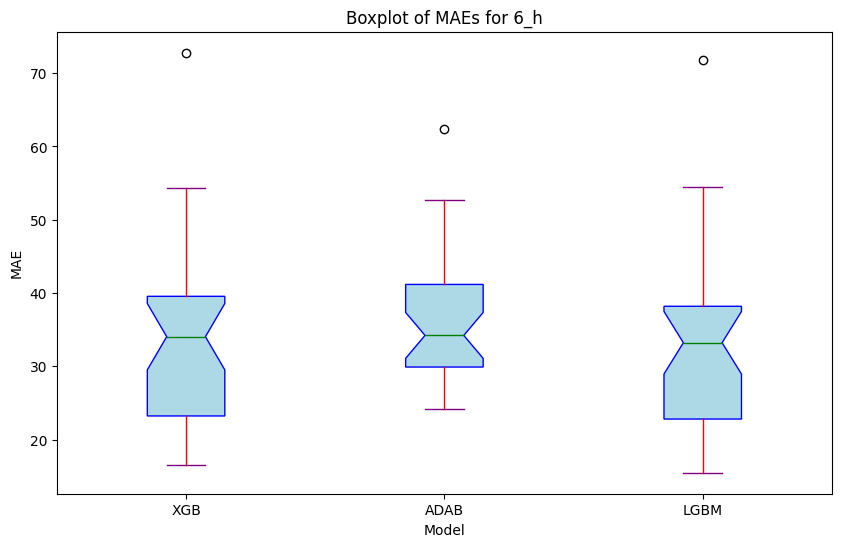

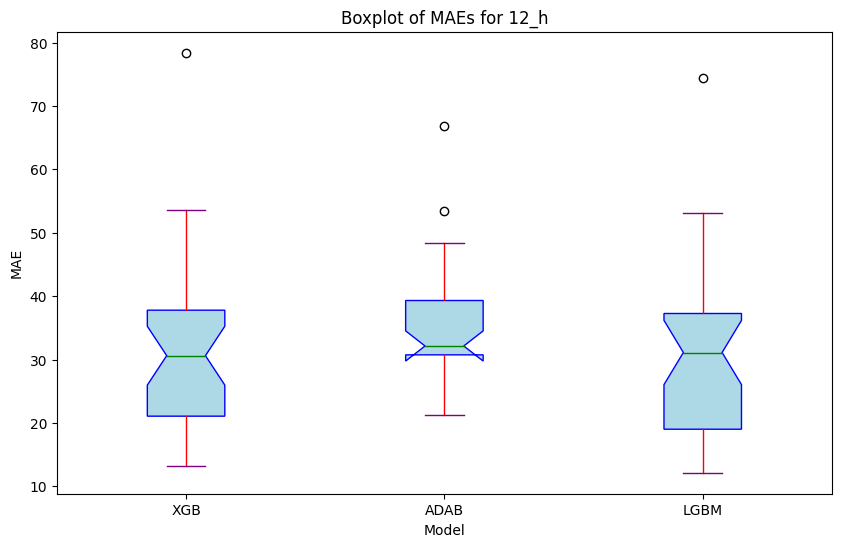

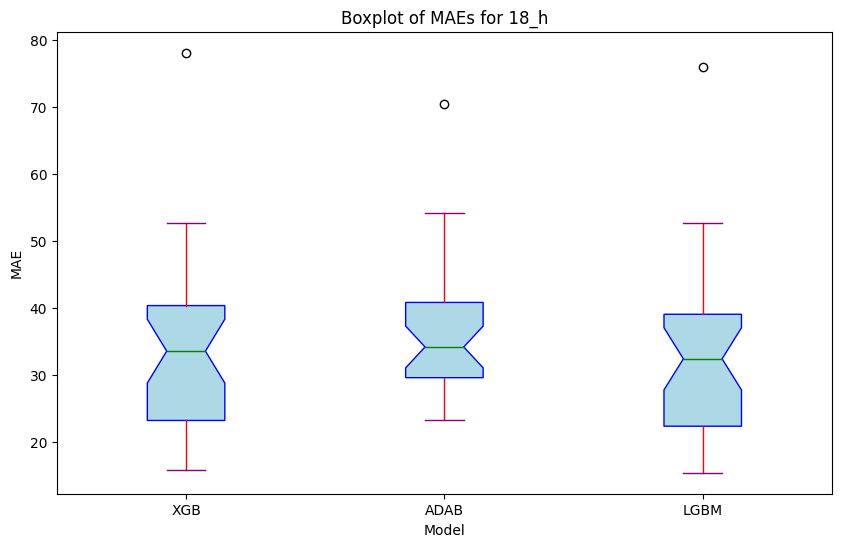

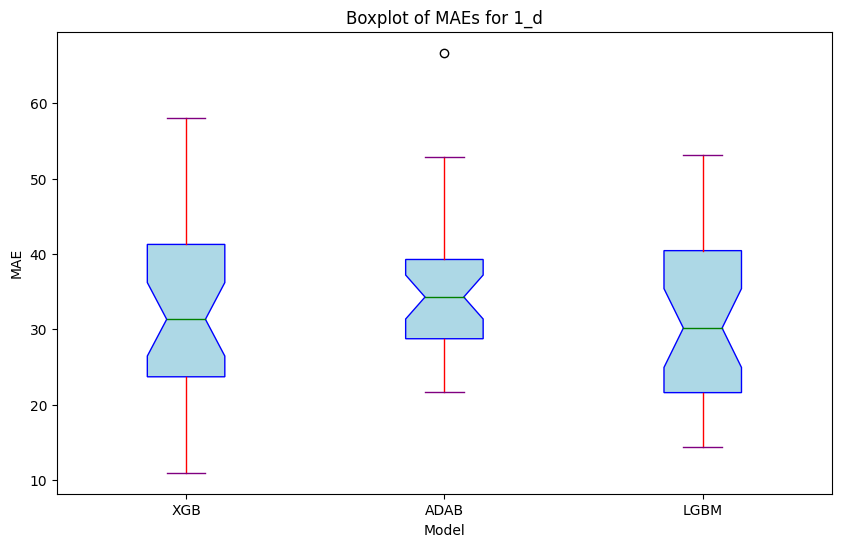

In [ ]:
#boxplot
create_boxplots(individual_maes)

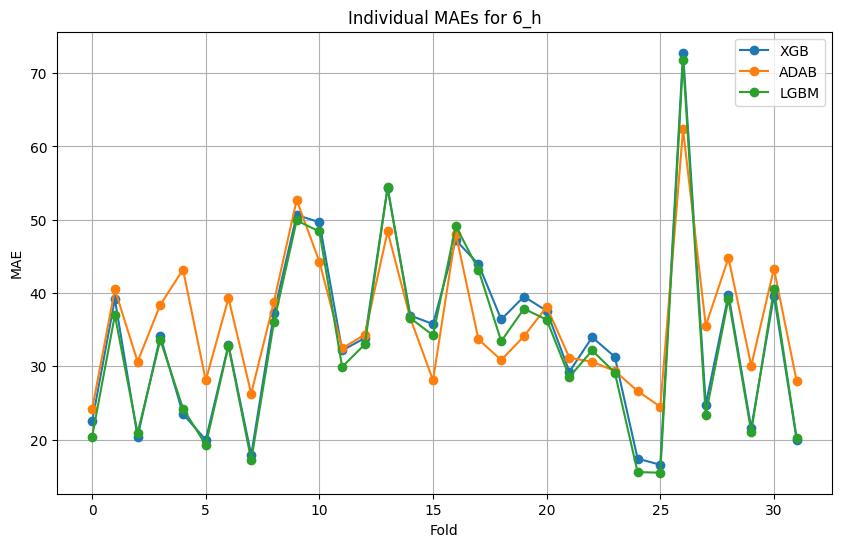

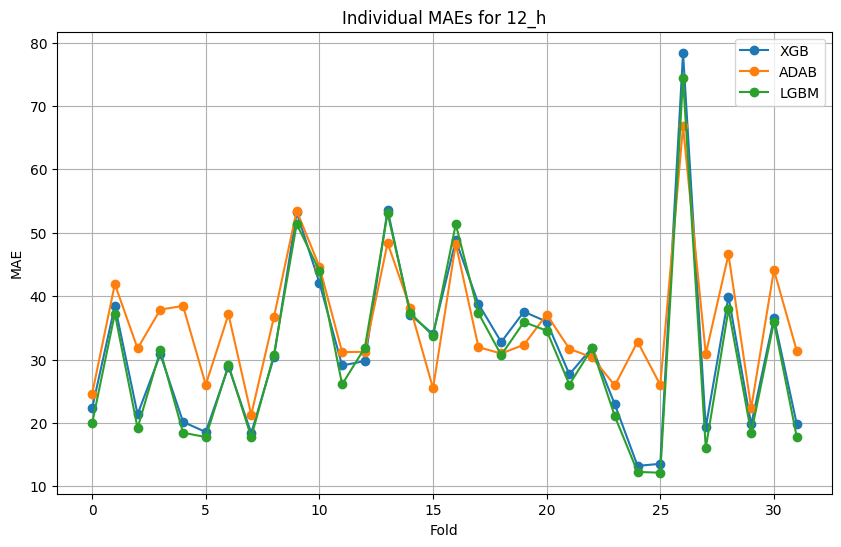

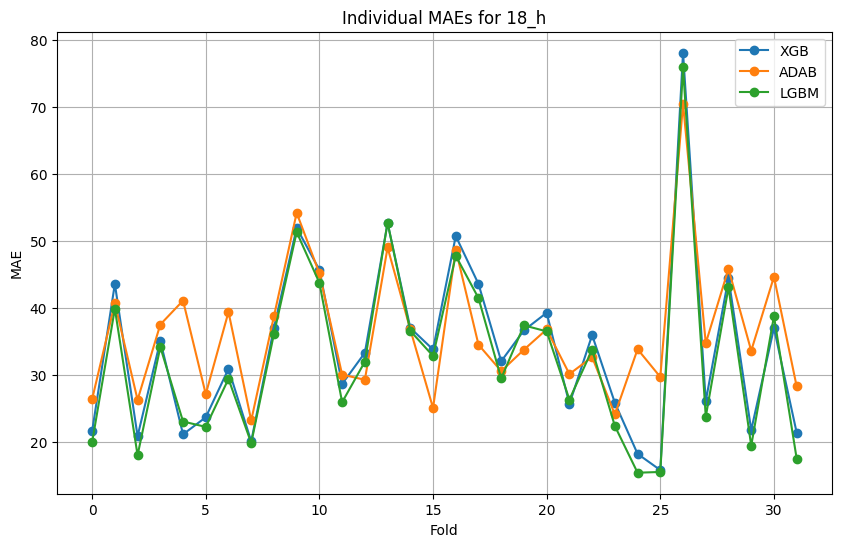

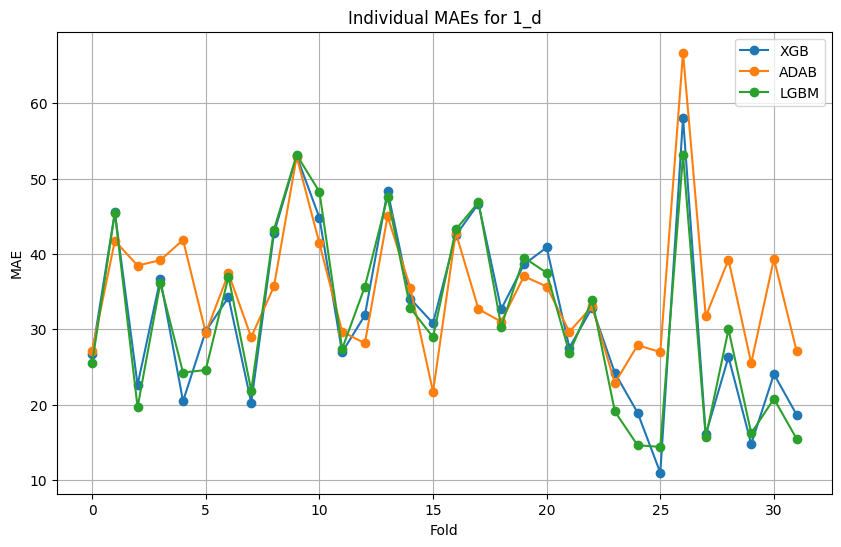

In [ ]:
#line plot
plot_lines(individual_maes)

### Modelling with scaling

In [ ]:
#scaling raw data
scaled_dataframes_6 = scale(combined_features_6, target_column='y')
scaled_dataframes_12 = scale(combined_features_12, target_column='y')
scaled_dataframes_18 = scale(combined_features_18, target_column='y')
scaled_dataframes_1_day = scale(combined_features_1_day, target_column='y')

In [ ]:
#modelling, only scale
dictionaries = {
    '6_h': scaled_dataframes_6,
    '12_h': scaled_dataframes_12,
    '18_h': scaled_dataframes_18,
    '1_d': scaled_dataframes_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 25.6186
  Using model ADAB...
    Average MAE: 33.5171
  Using model LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

In [ ]:
#mean day pred
mean_days = day_predict(individual_maes)
prettyp(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-15 02:18:30.200894
  ADAB: Mean prediction date and time = 2024-07-22 23:52:23.200894
  LGBM: Mean prediction date and time = 2024-07-13 16:48:21.200894

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-16 13:20:06.200894
  ADAB: Mean prediction date and time = 2024-07-24 22:19:09.200894
  LGBM: Mean prediction date and time = 2024-07-15 15:14:49.200894

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-15 01:32:22.200894
  ADAB: Mean prediction date and time = 2024-07-23 01:43:56.200894
  LGBM: Mean prediction date and time = 2024-07-14 01:56:55.200894

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-13 05:06:10.200894
  ADAB: Mean prediction date and time = 2024-07-21 01:32:52.200894
  LGBM: Mean prediction date and time = 2024-07-12 11:44:04.200894


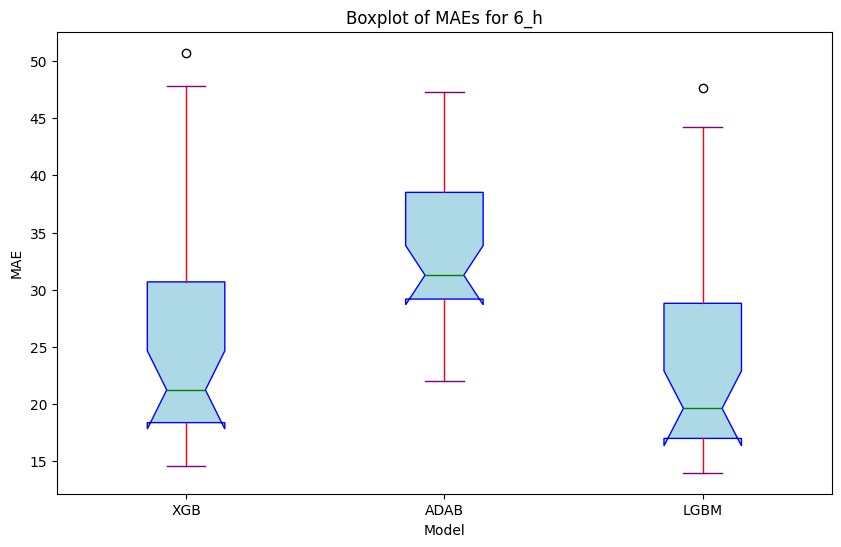

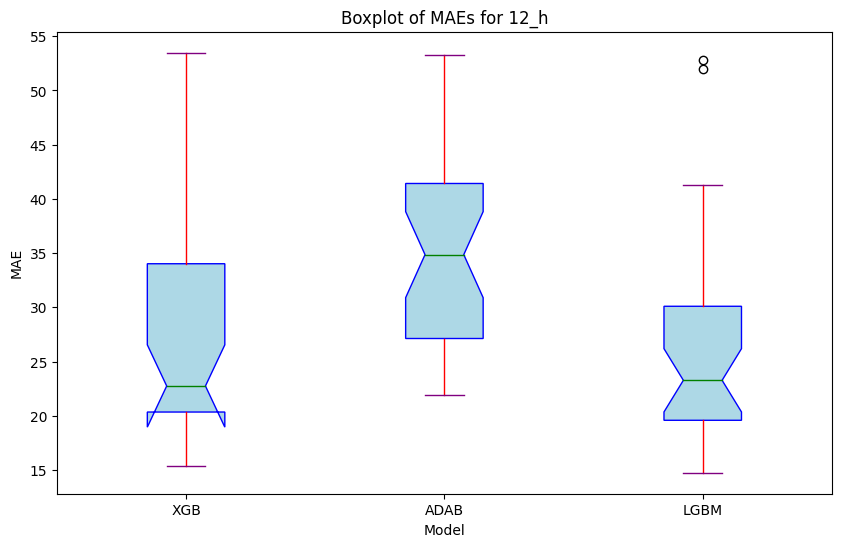

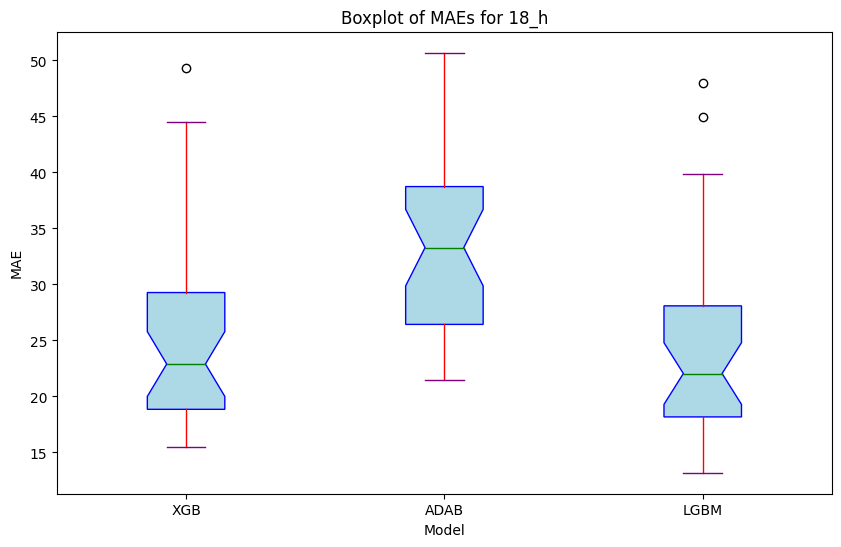

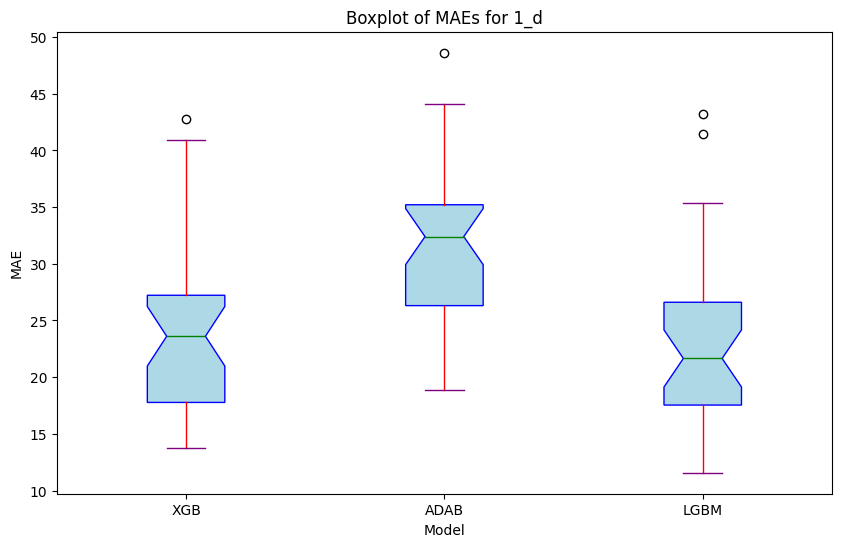

In [ ]:
#boxplot
create_boxplots(individual_maes)

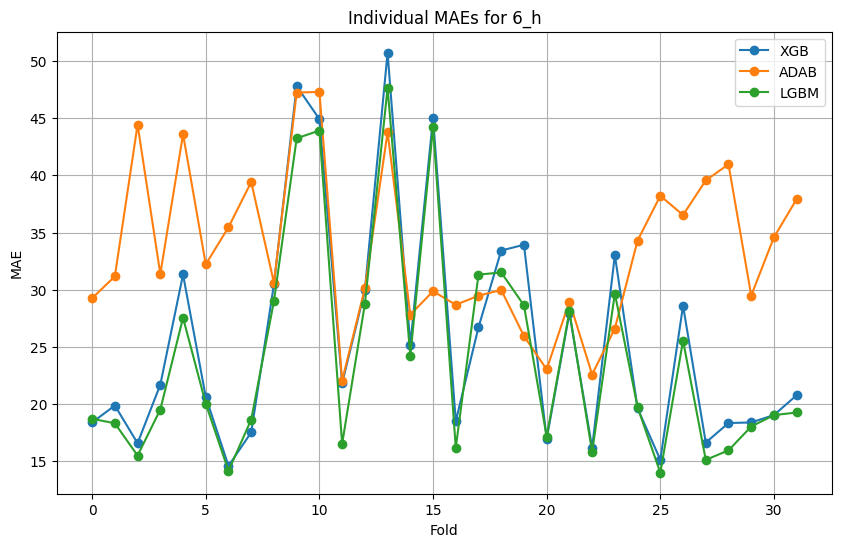

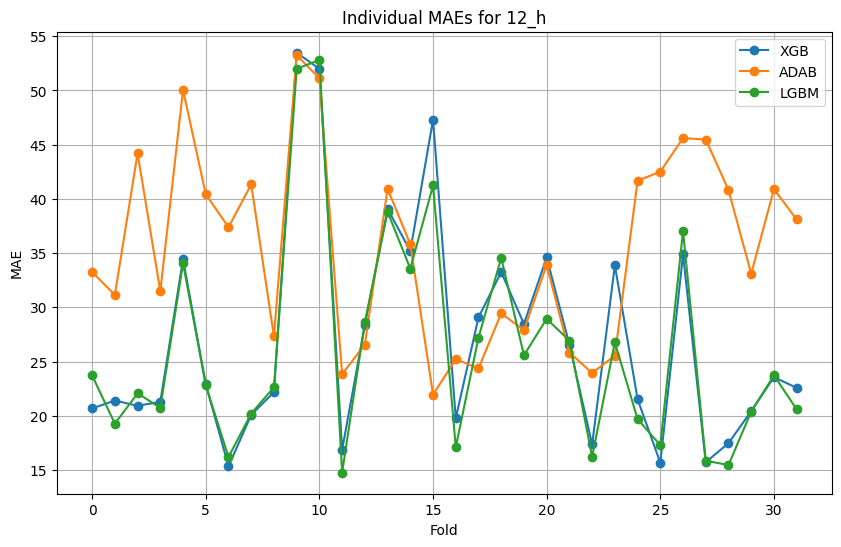

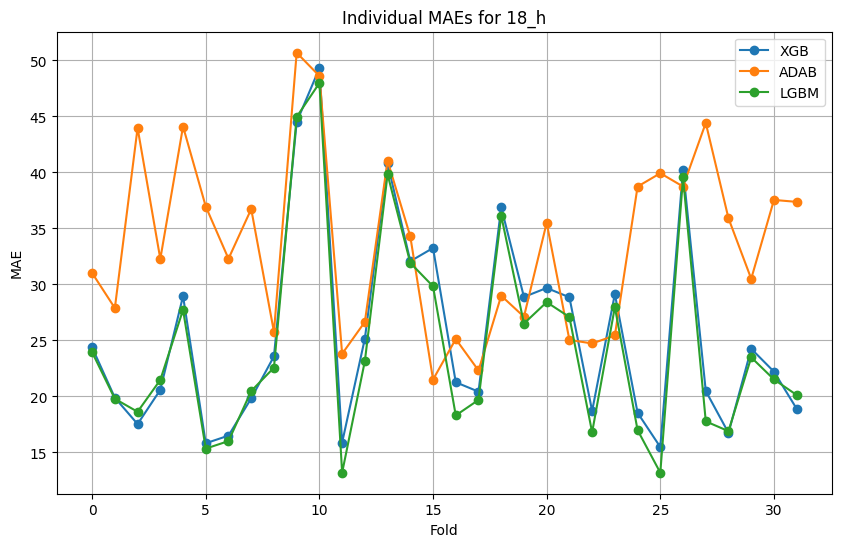

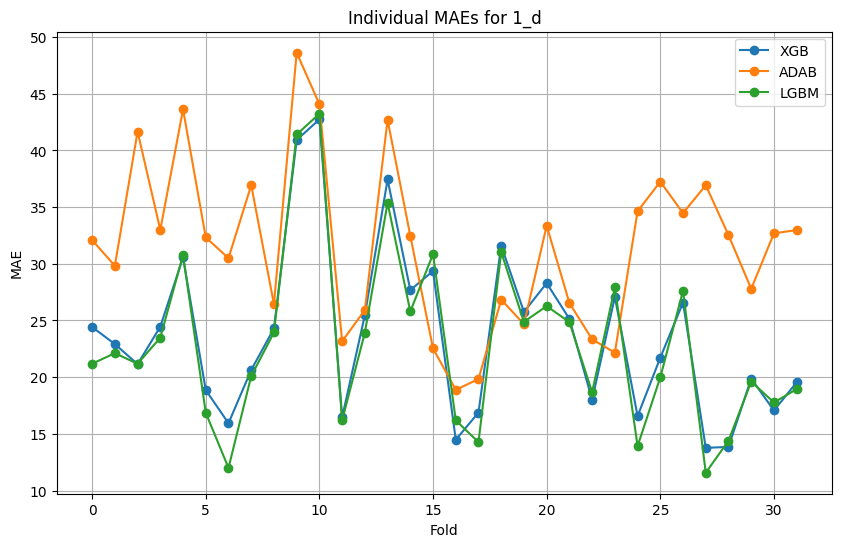

In [ ]:
#line plot
plot_lines(individual_maes)

## Regression with uncertainty 